# Восстановление золота из руды

## Цель работы

Подготовка прототипа модели машинного обучения для компании «Цифры», которая разрабатывает решения для эффективной работы промышленных предприятий.
Используя данные с параметрами добычи и очистки, модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## План работ

1. **Подготовка данных**
    + 1.1 Открыть файлы и изучить их.<br>
        Путь к файлам:<br>
        - /datasets/gold_industry_train.csv 
        - /datasets/gold_industry_test.csv
        - /datasets/gold_industry_full.csv
    + 1.2. Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака `rougher.output.recovery`. Найти MAE между нашими расчётами и значением признака. Описать выводы.
    + 1.3. Проанализировать признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
    + 1.4. Провести предобработку данных.
2. **Проанализировать данные**
    + 2.1. Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. Какие особенности имеют распределения? Описать выводы.
    + 2.2.  Сравнить распределения размеров гранул исходного сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
    + 2.3. Исследовать суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.
3. **Построить модель**
    + 3.1. Написать функцию для вычисления итоговой sMAPE.
    + 3.2. Обучить разные модели и оцените их качество кросс-валидацией. Выбрать лучшую модель и проверить её на тестовой выборке. Описать выводы.

## Описание данных

* **Технологический процесс**
    + Rougher feed — исходное сырье
    + Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    + Xanthate — ксантогенат (промотер, или активатор флотации);
    + Sulphate — сульфат (на данном производстве сульфид натрия);
    + Depressant — депрессант (силикат натрия).
    + Rougher process (англ. «грубый процесс») — флотация
    + Rougher tails — отвальные хвосты
    + Float banks — флотационная установка
    + Cleaner process — очистка
    + Rougher Au — черновой концентрат золота
    + Final Au — финальный концентрат золота
* **Параметры этапов**
    + air amount — объём воздуха
    + fluid levels — уровень жидкости
    + feed size — размер гранул сырья
    + feed rate — скорость подачи
* **Наименование признаков**
    - Наименование признаков должно быть такое: <br>
        [этап].[тип_параметра].[название_параметра]<br>
        Пример: rougher.input.feed_ag
    - Возможные значения для блока [этап]:
        + rougher — флотация
        + primary_cleaner — первичная очистка
        + secondary_cleaner — вторичная очистка
        + final — финальные характеристики
    - Возможные значения для блока [тип_параметра]:
        + input — параметры сырья
        + output — параметры продукта
        + state — параметры, характеризующие текущее состояние этапа
        + calculation — расчётные характеристики

## Необходимые формулы

Метрика качества
:

![smape](https://pictures.s3.yandex.net/resources/smape_1576239058.jpg)

где:
+ **y<sub>i</sub>** - значение целевого признака для объекта с порядковым номером *i* в выборке, на которой измеряется качество
+ **&#375;<sub>i</sub>** - значение предсказания для объекта с порядковым номером *i*, например, в тестовой выборке
+ **N** - количество объектов в выборке.

Итоговая метрика:

![final_smape](https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg)

Эффективность обогащения:

![recovery](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg)

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

## Подготовка данных

Для начала импортируем необходимые библиотеки:

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import RandomState
from scipy import stats as st
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_predict,
    cross_val_score,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

pd.set_option("display.max_columns", None)
state = RandomState(42)

### Загрузка и изучение датасетов:

In [2]:
try:
    train_df = pd.read_csv("\datasets\gold_industry_train.csv")
    test_df = pd.read_csv("\datasets\gold_industry_test.csv")
    full_df = pd.read_csv("\datasets\gold_industry_full.csv")
except:
    train_df = pd.read_csv("datasets\gold_industry_train.csv")
    test_df = pd.read_csv("datasets\gold_industry_test.csv")
    full_df = pd.read_csv("datasets\gold_industry_full.csv")
df = {"train": train_df, "test": test_df, "full": full_df}

for i in df.items():
    print(str(i[0]) + ":")
    display(i[1].head())
    i[1].info()
    print("")

train:


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,11.836743,6.005818,41885.707031,3481.779053,3520.337158,2.838687,19.793808,11.500771,7.101074,28.029297,87.107763,1.170244,5.008018,0.508728,19.154297,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,34.174427,8.547551,10.389648,19.529297,2.106679,14.936526,2.534912,7.476074,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,2.606185,14.500184,4.694824,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,1600.754587,-449.953435,1600.47

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,1147.248241,-500.363165,1047.279065,-500.354091,948.756608,-498.439416,849.441918,-499.255503,850.112246,-499.407112,6.168939,9.309852,95.248427,8.078957,6.500000,1.283045,1648.759906,-399.862053,1650.135395,-399.957321,1648.831890,-400.586116,1649.464582,-400.673303,34.940919,-500.150510,30.031867,-500.328335,26.033990,-500.147792,22.952306,-500.037678,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561,6.209517,9.297194,98.880538,7.984164,6.500000,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,1651.498591,-399.745329,34.980742,-498.131002,29.968453,-586.013330,25.971737,-499.608392,22.958448,-499.821308,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,1150.754676,-499.986009,1049.182824,-500.014696,948.085464,-499.997003,850.170086,-500.270334,849.557905,-500.198702,7.358308,9.000624,119.497545,8.003752,6.500000,1.259741,1647.368779,-399.788506,1648.395206,-400.166490,1648.953828,-400.468641,1649.821569,-400.071884,34.952967,-501.204647,29.927025,-500.106628,25.978253,-499.890060,23.004376,-500.014529,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,1152.512559,-500.338106,1052.601592,-499.695075,955.171539,-500.294989,851.957342,-499.779541,850.765662,-501.030559,6.929364,8.920717,108.080163,7.970121,6.660000,0.774909,1652.660845,-399.702218,1651.203128,-400.291472,1651.924848,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,11.836743,6.005818,41885.707031,3481.779053,3520.337158,2.838687,19.793808,11.500771,7.101074,28.029297,87.107763,1.170244,5.008018,0.508728,19.154297,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,34.174427,8.547551,10.389648,19.529297,2.106679,14.936526,2.534912,7.476074,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,2.606185,14.500184,4.694824,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,1600.754587,-449.953435,1600.47

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


У всех датафреймов колонка *date* имеет неверный тип данных, требуется ***datetime64***. Во многих колонках имеются пропуски. Количество колонок в тестовой таблице *test_df* (53) не соответствует количеству колонок в  таблицах *full_df* и *train_df* (87).

### Проверка расчета эффективности обогащения

Воспользуемся формулой и вычислим эффективность обогащения на обучающей выборке, затем проверим с помощью метрики ***MAE*** вычисленные значения с приведенными в таблице:

In [3]:
C = train_df["rougher.output.concentrate_au"]
F = train_df["rougher.input.feed_au"]
T = train_df["rougher.output.tail_au"]

recovery = (C * (F - T)) / (F * (C - T)) * 100

print("MAE = ", MAE(train_df["rougher.output.recovery"], recovery))

MAE =  9.83758577644259e-15


Как видим, разница между вычисленными и приведенными в таблице значениями очень маленькая, значит эффективность обогащения рассчитана правильно. 

### Анализ недоступных в тестовой выборке признаков.

Список признаков, которых нет в тестовой выборке:

In [4]:
diff_columns = sorted(list(set(full_df).difference(set(test_df))))
display(diff_columns)

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

+ Отсутствует эффективность обогащения чернового концентрата ***rougher.output.recovery***
+ Эффективность обогащения финального концентрата ***final.output.recovery***

* Для всех этапов отсутствует информация об отвальных хвостах
* Для всех этапов, кроме второго этапа очистки, отсутствует информация о выходных концентратах (продуктах)

- Для этапа флотации отсутствует расчётные характеристики:
    * ***rougher.calculation.au_pb_ratio***
    * ***rougher.calculation.floatbank10_sulfate_to_au_feed***
    * ***rougher.calculation.floatbank11_sulfate_to_au_feed***



### Предобработка данных

Сначала поменяем тип данных колонки времени для всех датафреймов:

In [5]:
# Заменим тип данных признака date на datetime
for i in df.items():
    i[1]["date"] = pd.to_datetime(i[1]["date"], format="%Y-%m-%d %H:%M:%S")
    print(
        "Тип данных колонки " "date" " таблицы {}: {}".format(i[0], i[1]["date"].dtype)
    )

Тип данных колонки date таблицы train: datetime64[ns]
Тип данных колонки date таблицы test: datetime64[ns]
Тип данных колонки date таблицы full: datetime64[ns]


Проверим наличие полных дубликатов:

In [6]:
for i in df.items():
    print("Дубликатов строк в таблице {}: {}".format(i[0], i[1].duplicated().sum()))

Дубликатов строк в таблице train: 0
Дубликатов строк в таблице test: 0
Дубликатов строк в таблице full: 0


В вводной информации сказано, что данные индексируются датой и временем получения информации (признак date) и соседние по времени параметры часто похожи. Для борьбы с пропусками воспользуемся методом *ffillna* из библиотеки Pandas :

In [7]:
for i in df.items():
    i[1].fillna(axis=0, method="ffill", inplace=True)
    s = 0
    print("")
    print("==============================================")
    for j in i[1].columns:
        if i[1][j].isnull().sum() > 0:
            s += 1
            print(
                "Количество пропусков в столбце {} датафрейма {}: {}".format(
                    j, i[0], i[1][j].isnull().sum()
                )
            )
    if s == 0:
        print("В датафрейме {} пропусков нет".format(i[0]))
        display(i[1].info())


В датафрейме train пропусков нет
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14579 non-null  datetime64[ns]
 1   rougher.input.feed_au                               14579 non-null  float64       
 2   rougher.input.feed_ag                               14579 non-null  float64       
 3   rougher.input.feed_pb                               14579 non-null  float64       
 4   rougher.input.feed_sol                              14579 non-null  float64       
 5   rougher.input.feed_rate                             14579 non-null  float64       
 6   rougher.input.feed_size                             14579 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   14579 no

None


В датафрейме test пропусков нет
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        4860 non-null   datetime64[ns]
 1   rougher.input.feed_au                       4860 non-null   float64       
 2   rougher.input.feed_ag                       4860 non-null   float64       
 3   rougher.input.feed_pb                       4860 non-null   float64       
 4   rougher.input.feed_sol                      4860 non-null   float64       
 5   rougher.input.feed_rate                     4860 non-null   float64       
 6   rougher.input.feed_size                     4860 non-null   float64       
 7   rougher.input.floatbank10_sulfate           4860 non-null   float64       
 8   rougher.input.floatbank10_xanthate          4860 non-nu

None


В датафрейме full пропусков нет
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   rougher.input.feed_au                               19439 non-null  float64       
 2   rougher.input.feed_ag                               19439 non-null  float64       
 3   rougher.input.feed_pb                               19439 non-null  float64       
 4   rougher.input.feed_sol                              19439 non-null  float64       
 5   rougher.input.feed_rate                             19439 non-null  float64       
 6   rougher.input.feed_size                             19439 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   19439 non

None

### Промежуточный итог

1. Загрузили данные. Изучили какие есть проблемы:
    + Наличие пропусков в столбцах
    + Колонка date имеет неверный тип данных (object), требуется datetime64
    + Количество колонок в тестовой таблице test_df (53) не соответствует количеству колонок в таблицах full_df и train_df (87)
2. Вычислили эффективность обогащения на обучающей выборке, затем проверили с помощью метрики MAE вычисленные значения с приведенными в таблице. Результат показал, что приведенные в таблице данные ***корректны***.
3. Выяснили, какие признаки недоступны в тестовой выборке.
4. Провели предобработку данных:
    + Поменяли тип данных у колонок *date* на *datetime64*
    + Проверили наличие дубликатов строк. Их не оказалось
    + С помощью метода *ffillna* заполнили пропуски во всех колонках


## Анализ данных

### Изменение концентрации металлов (Au, Ag, Pb) на различных этапах

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Для этого создадим отдельную таблицу каждого металла, где столбцы будут отвечать за концентрацию данного элемента на текущем этапе: 

In [8]:
# функция для удобства создания таблиц
def metall(df_loc, name):
    df_X = df_loc[
        [
            "rougher.input.feed_" + name,
            "rougher.output.concentrate_" + name,
            "primary_cleaner.output.concentrate_" + name,
            "final.output.concentrate_" + name,
        ]
    ]
    df_X = df_X.rename(
        columns={
            "rougher.input.feed_" + name: "feed",
            "rougher.output.concentrate_" + name: "rough",
            "primary_cleaner.output.concentrate_" + name: "primary",
            "final.output.concentrate_" + name: "final",
        }
    )
    return df_X

In [9]:
df_Au = metall(full_df, "au")
print("========================================================================")
print("Датафрейм Au:")
display(df_Au.head())


df_Ag = metall(full_df, "ag")
print("========================================================================")
print("Датафрейм Ag:")
display(df_Ag.head())


df_Pb = metall(full_df, "pb")
print("========================================================================")
print("Датафрейм Pb:")
display(df_Pb.head())

# для удобства сохраним в словарь полученные таблицы
df_metal = {"Au": df_Au, "Ag": df_Ag, "Pb": df_Pb}

Датафрейм Au:


,feed,rough,primary,final
0,6.486150,19.793808,34.174427,42.192020
1,6.478583,20.050975,34.118526,42.701629
2,6.362222,19.737170,33.969464,42.657501
3,6.118189,19.320810,28.260743,42.689819
4,5.663707,19.216101,33.044932,42.774141


Датафрейм Ag:


,feed,rough,primary,final
0,6.100378,11.500771,8.547551,6.055403
1,6.161113,11.615865,8.558743,6.029369
2,6.116455,11.695753,8.603505,6.055926
3,6.043309,11.915047,7.221879,6.047977
4,6.060915,12.411054,9.089428,6.148599


Датафрейм Pb:


,feed,rough,primary,final
0,2.284912,7.101074,10.389648,9.889648
1,2.266033,7.278807,10.497069,9.968944
2,2.159622,7.216833,10.354494,10.213995
3,2.037807,7.175616,8.496563,9.977019
4,1.786875,7.240205,9.986786,10.142511


Построим гистограмму по средними значениями каждого этапа для наглядности изменения значений концентратов:

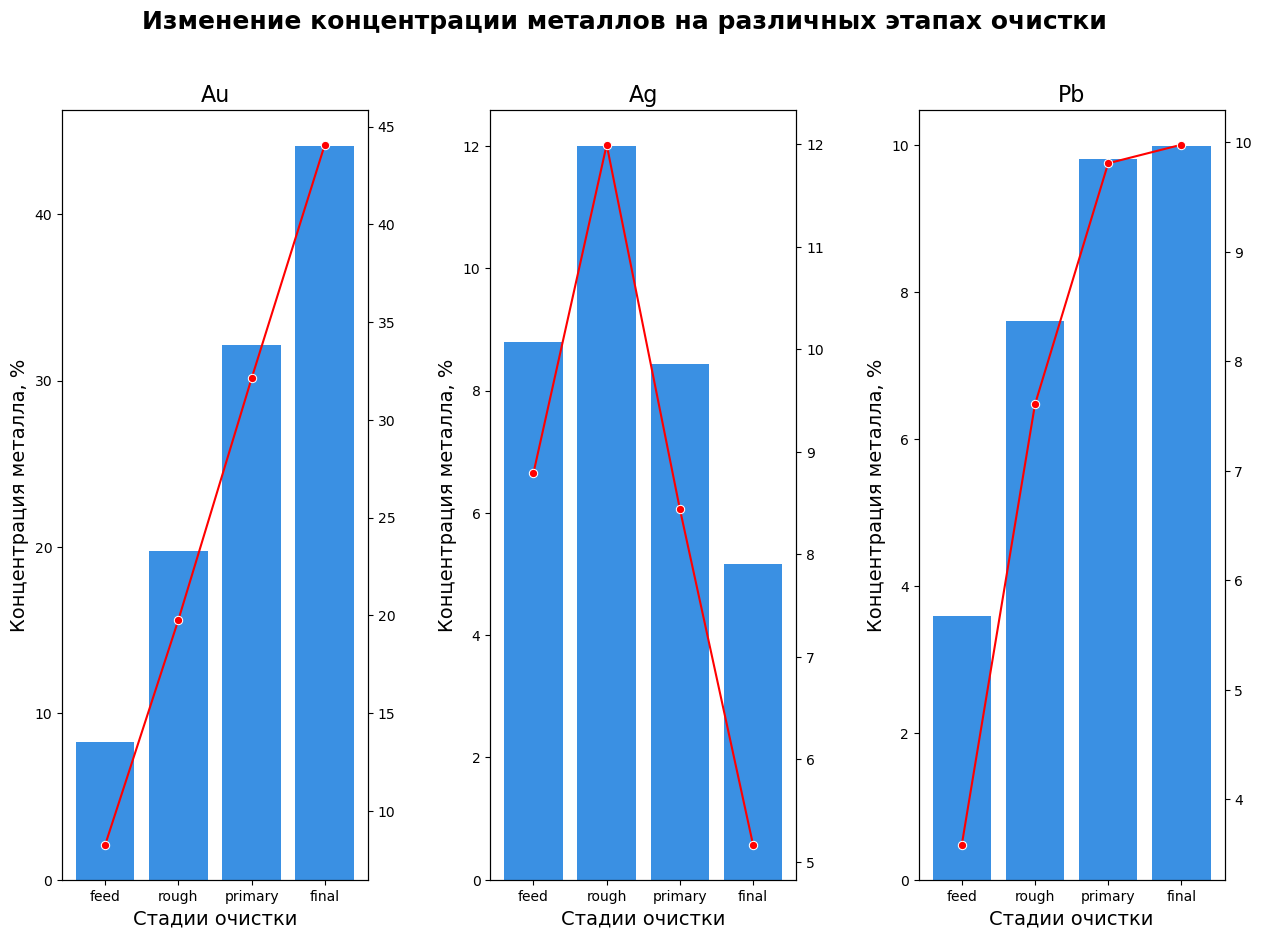

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.2)
j = 0
for i in df_metal.items():
    ax = sns.barplot(
        x=i[1].columns, y=i[1][i[1].columns].mean(), color="dodgerblue", ax=axs[j]
    )
    ax.set_title(i[0], fontsize=16)
    ax.set_ylabel("Концентрация металла, %", fontsize=14)
    ax.set_xlabel("Стадии очистки", fontsize=14)
    ax1 = ax.twinx()
    ax1 = sns.lineplot(
        x=i[1].columns,
        y=i[1][i[1].columns].mean(),
        marker="o",
        color="red",
        sort=False,
        ax=ax1,
    )
    j += 1

plt.suptitle(
    "Изменение концентрации металлов на различных этапах очистки",
    fontsize=18,
    fontweight="bold",
);

1. Серебро Ag:
    + Концентрация уменьшается в процессе очистки. Финальная концентрация равна 0.5%. Максимальная концентрация после флотации.
2. Свинец Pb:
    + Концентрация на каждом этапе растет (с 0.5% до 10%)
3. Золото Au:
    + Концентрация **линейно** растет (от 1% до 45%)

### Сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках.

Построим гистограммы для размеров гранул в относительных частотах:

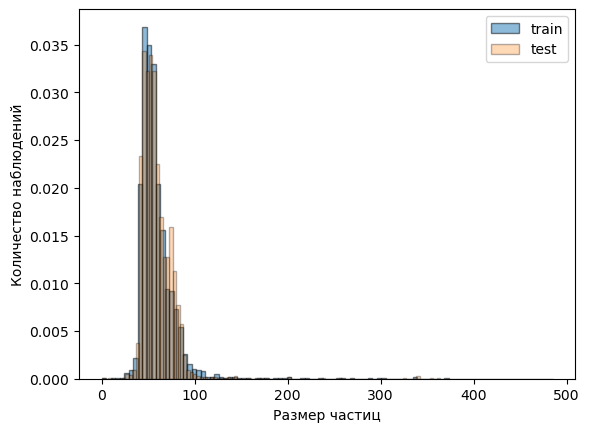

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(
    train_df["rougher.input.feed_size"],
    bins=100,
    alpha=0.5,
    label="train",
    edgecolor="black",
    density=True,
)
ax.hist(
    test_df["rougher.input.feed_size"],
    bins=100,
    alpha=0.3,
    label="test",
    edgecolor="black",
    density=True,
)

plt.xlabel("Размер частиц")
plt.ylabel("Количество наблюдений")
plt.legend();

In [12]:
print("================================================")
print("Распределение размеров гранул обучающей выборки:")
display(train_df["rougher.input.feed_size"].describe())
print("")
print("===============================================")
print("Распределение размеров гранул тестовой выборки:")
display(test_df["rougher.input.feed_size"].describe())

Распределение размеров гранул обучающей выборки:


count    14579.000000
mean        59.070865
std         22.903811
min          0.049194
25%         47.322462
50%         54.464259
75%         64.469177
max        484.967466
Name: rougher.input.feed_size, dtype: float64


Распределение размеров гранул тестовой выборки:


count    4860.000000
mean       59.136150
std        19.512497
min         0.046369
25%        47.610795
50%        55.461058
75%        66.538910
max       363.989699
Name: rougher.input.feed_size, dtype: float64

Также можем проверить гипотезу о равенстве средних значений размеров гранул исходного сырья на обучающей и тестовой выборках с помощью двустороннего теста:
* Нулевая гипотеза будет выглядеть следующим образом:<br>
         <b>H<sub>0</sub></b> - средние размеры гранул исходного сырья на обучающей и тестовой выборках равны.<br>
* Альтернативная гипотеза:<br>
         <b>H<sub>1</sub></b> - средние размеры гранул исходного сырья на обучающей и тестовой выборках **НЕ** равны.

In [13]:
# уровень статистической значимости
alpha = 0.01

# двусторонняя гипотеза
results = st.ttest_ind(
    train_df["rougher.input.feed_size"],
    test_df["rougher.input.feed_size"],
    equal_var=False,
    alternative="two-sided",
)

print("p-значение:", results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8468970428326675
Не получилось отвергнуть нулевую гипотезу


Отвергнуть нулевую гипотезу не удалось, значит весьма допустимо, что средние значения размеров гранул исходного сырья на обучающей и тестовой выборках ***равны***

Как видим, гистограммы у обоих выборок имеют схожую форму. Также описательная статистика показывает, что основные параметры выборок одинаковые (среднее, медиана, квантили). Лишь немного отличаются стандартные отклонения. Также проверили гипотезу о равенстве средних значений выборок - отвергнуть гипотезу о том, что средние значения размеров гранул исходного сырья на обучающей и тестовой выборках равны не удалось.  </br>
Значит можно считать, что распределения друг от друга отличаются **слабо**.

### Суммарная концентрация металлов на разных стадиях

Исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. Для начала найдем суммарную концентрацию металлов на каждом из этапов:

In [14]:
# функция для удобства создания таблиц
def sum_metall(df_loc, stage):
    df_X = df_loc[
        [
            stage + "_ag",
            stage + "_pb",
            stage + "_sol",
            stage + "_au",
        ]
    ].sum(axis=1)
    return df_X

Создадим датафрейм, в котором каждый столбцы будут соответствовать этапам обработки, а значениями будут суммарные концентрации металлов:

In [15]:
stages = [
    "rougher.input.feed",
    "rougher.output.concentrate",
    "primary_cleaner.output.concentrate",
    "final.output.concentrate",
]
metall_in_stage = pd.DataFrame()
metall_col = ["Сырье", "Флотация", "Первичная очистка", "Финал"]
j = 0
for i in stages:
    metall_in_stage[metall_col[j]] = sum_metall(full_df, i)
    j += 1
metall_in_stage.head()

,Сырье,Флотация,Первичная очистка,Финал
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667


Построим гистограммы:

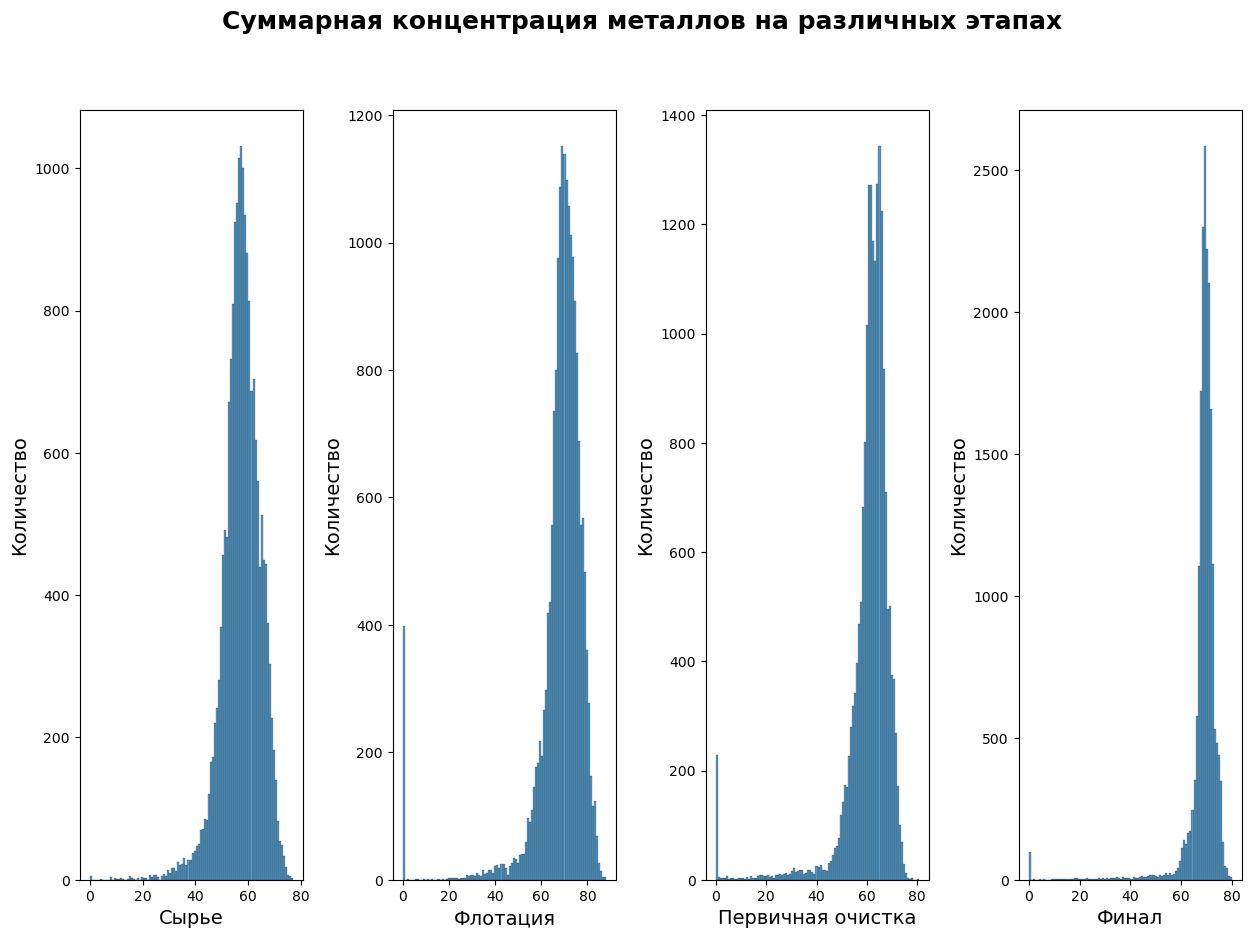

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(15, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.2)

for i in range(0, len(metall_col)):
    ax = sns.histplot(
        metall_in_stage[metall_col[i]],
        fill=True,
        bins=100,
        palette="coolwarm",
        ax=axs[i],
    )
    ax.set_ylabel("Количество", fontsize=14)
    ax.set_xlabel(metall_col[i], fontsize=14)

plt.suptitle(
    "Суммарная концентрация металлов на различных этапах",
    fontsize=18,
    fontweight="bold",
);

Видим, что есть очевидные выбросы около 0, избавимся от них. Сначала посмотрим сколько данных со значением меньше 1:

In [17]:
for i in range(0, len(metall_col)):
    print(
        metall_col[i]
        + ": "
        + str(
            metall_in_stage[metall_col[i]]
            .loc[metall_in_stage[metall_col[i]] <= 1]
            .count()
        )
    )

Сырье: 5
Флотация: 399
Первичная очистка: 228
Финал: 99


Теперь избавимся от этих значений:

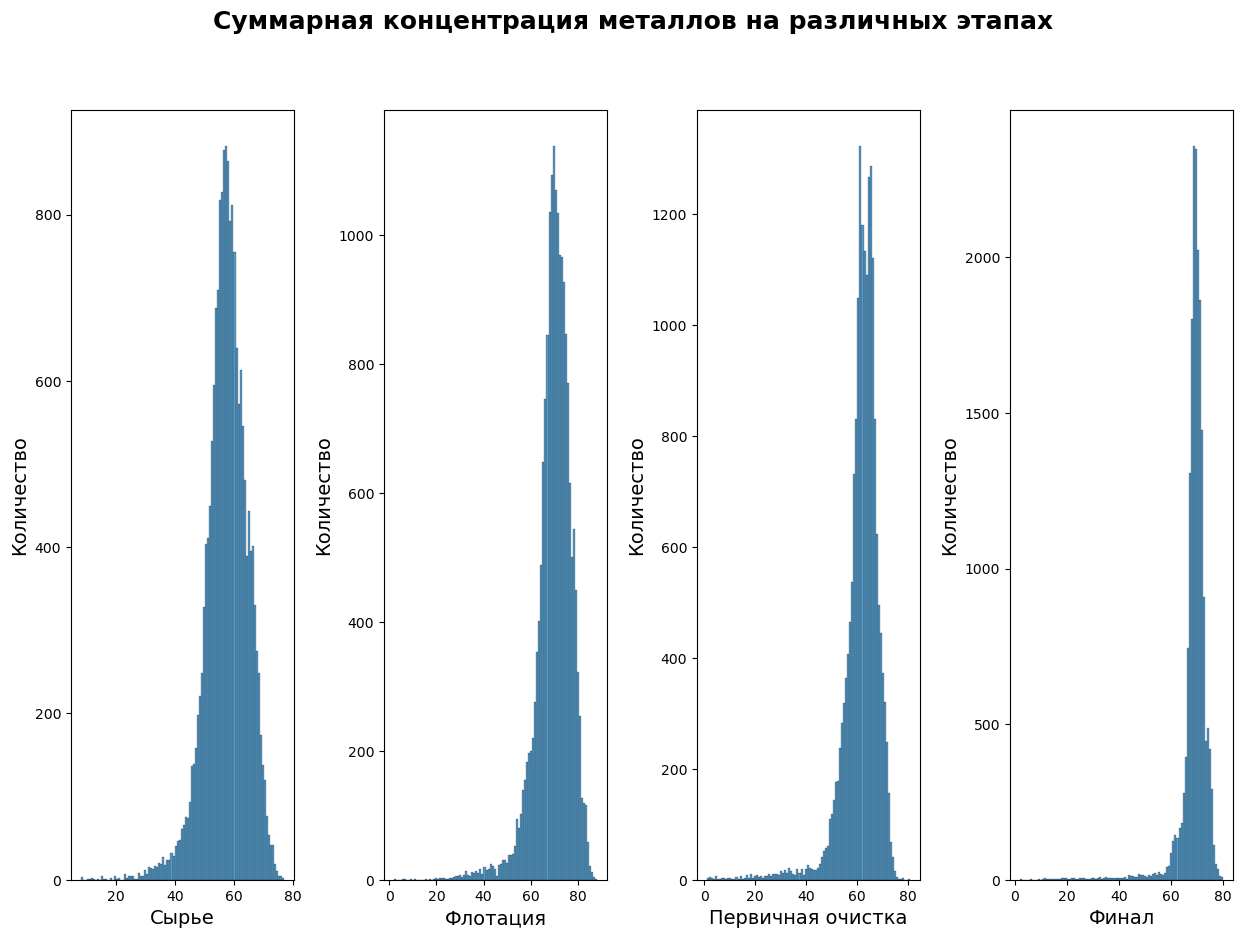

In [18]:
for i in range(0, len(metall_col)):
    metall_in_stage = metall_in_stage.loc[metall_in_stage[metall_col[i]] > 1]

fig, axs = plt.subplots(1, 4, figsize=(15, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.2)


for i in range(0, len(metall_col)):
    ax = sns.histplot(
        metall_in_stage[metall_col[i]],
        fill=True,
        bins=100,
        palette="coolwarm",
        ax=axs[i],
    )
    ax.set_ylabel("Количество", fontsize=14)
    ax.set_xlabel(metall_col[i], fontsize=14)

plt.suptitle(
    "Суммарная концентрация металлов на различных этапах",
    fontsize=18,
    fontweight="bold",
);

Также можем оценить среднюю суммарную концентрацию металлов на каждом этапе:

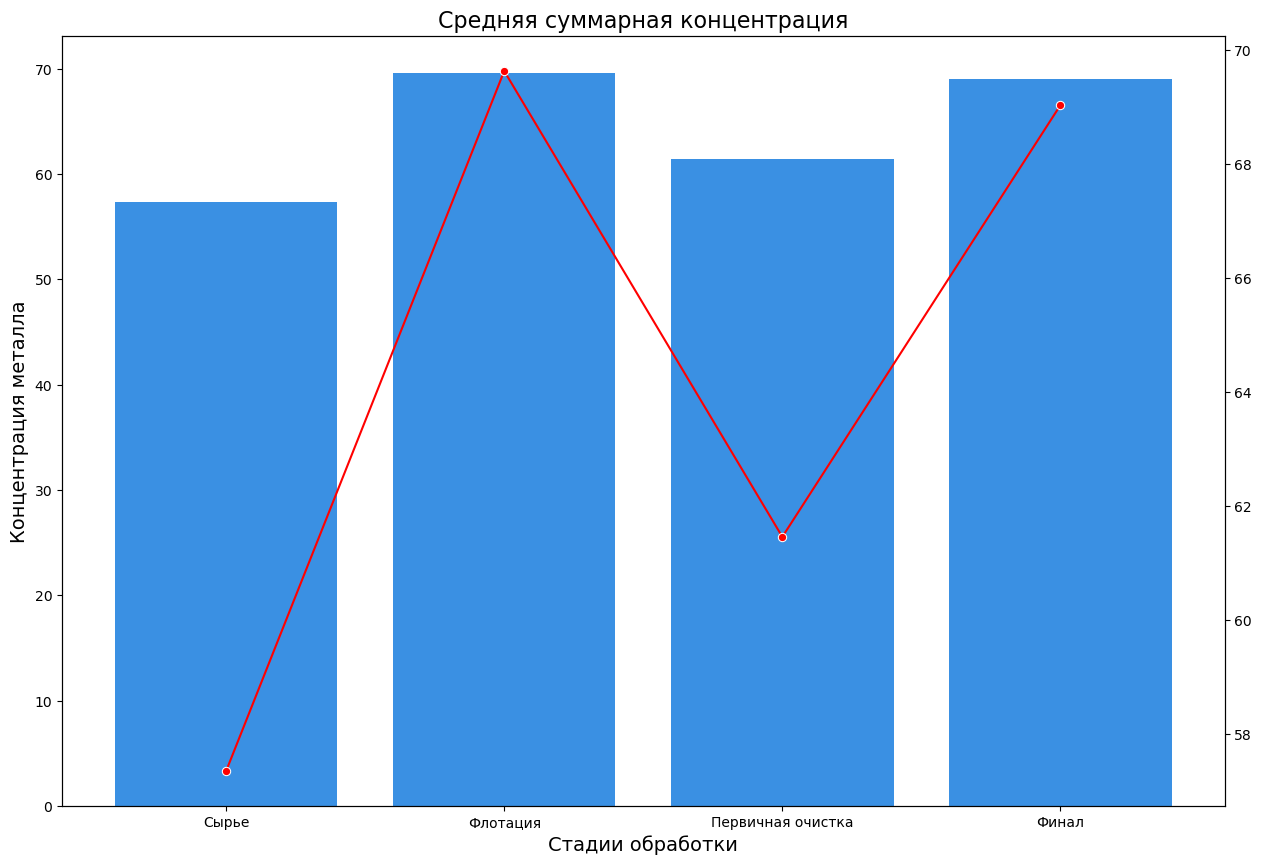

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.2)

ax = sns.barplot(
    x=metall_in_stage.columns, y=metall_in_stage.mean(), color="dodgerblue"
)
ax.set_title("Средняя суммарная концентрация", fontsize=16)
ax.set_ylabel("Концентрация металла", fontsize=14)
ax.set_xlabel("Стадии обработки", fontsize=14)
ax1 = ax.twinx()
ax1 = sns.lineplot(
    x=metall_in_stage.columns,
    y=metall_in_stage.mean(),
    marker="o",
    color="red",
    sort=False,
)

Суммарная средняя концентрация металлов в целом растет. 

Оставим в тестовой и обучающей выборках только строки с теми индексами, которые остались в датафрейме с суммарной концентрацией после удаления выбросов: 

In [20]:
print("Количество элементов ДО учета выбросов:")
print("train = ", len(train_df))
print("test = ", len(test_df))


train_df = train_df.iloc[sorted(list(set(train_df.index) & set(metall_in_stage.index)))]
test_df = test_df.iloc[sorted(list(set(test_df.index) & set(metall_in_stage.index)))]

print("Количество элементов ПОСЛЕ:")
print("train = ", len(train_df))
print("test = ", len(test_df))

Количество элементов ДО учета выбросов:
train =  14579
test =  4860
Количество элементов ПОСЛЕ:
train =  13883
test =  4726


Посчитали суммарную концентрацию металлов на разных стадиях обработки. Выяснили, что есть выбросы у значений близких к 0, избавились от этих выбросов в датафрейме с суммарными концентрациями и соответствующих данных в датафреймах с остальными параметрами (обучающая, тестовая)

### Промежуточный вывод

1. Концентрации металоов:
    + Серебро Ag:
        - Концентрация уменьшается в процессе очистки. Финальная концентрация равна 0.5%. Максимальная концентрация после флотации.
    + Свинец Pb:
        - Концентрация на каждом этапе растет (с 0.5% до 10%)
    + Золото Au:
        - Концентрация линейно растет (от 1% до 45%)
2. Распределения размеров гранул исходного сырья на обучающей и тестовой выборках отличаются **слабо**
3. Посчитали суммарную концентрацию металлов на разных стадиях обработки. Данные сохранили в отдельную таблицу *metall_in_stage*. Выяснили, что есть выбросы значений близких к 0, избавились от этих выбросов в датафрейме с суммарными концентрациями и от соответствующих данных в датафреймах с остальными параметрами (обучающая, тестовая).

## Модель

### Функция для вычисления итоговой sMAPE


Функция для  **sMAPE**:

In [21]:
def sMAPE(y_true, y_pred):
    error = np.mean(abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2)) * 100
    return error

Функция для итоговой **sMAPE**:

In [22]:
def final_sMAPE(sMAPE_rougher, sMAPE_final):
    return abs(0.25 * sMAPE_rougher + 0.75 * sMAPE_final)

Создадим оболочку для функции оценки качества ***sMAPE*** для использования в подборе гиперпараметров и кросс-валидации:

In [23]:
smape_score = make_scorer(sMAPE, greater_is_better=False)

### Подготовка данных

Добавим в тестовую выборку целевые признаки и удалим колонку с датой (на целевой признак она не влияет):

In [24]:
df_target = full_df[["date", "rougher.output.recovery", "final.output.recovery"]]
test_df = test_df.merge(df_target, how="left", on="date")
test_df.drop(["date"], axis=1, inplace=True)
test_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4726 entries, 0 to 4725
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4726 non-null   float64
 1   rougher.input.feed_ag                       4726 non-null   float64
 2   rougher.input.feed_pb                       4726 non-null   float64
 3   rougher.input.feed_sol                      4726 non-null   float64
 4   rougher.input.feed_rate                     4726 non-null   float64
 5   rougher.input.feed_size                     4726 non-null   float64
 6   rougher.input.floatbank10_sulfate           4726 non-null   float64
 7   rougher.input.floatbank10_xanthate          4726 non-null   float64
 8   rougher.state.floatbank10_a_air             4726 non-null   float64
 9   rougher.state.floatbank10_a_level           4726 non-null   float64
 10  rougher.stat

Далее удалим из обучающей выборки колонки которых нет в тестовой (кроме целевых признаков) и также *date*:

In [25]:
pd.options.mode.chained_assignment = None
diff_columns.remove("rougher.output.recovery")
diff_columns.remove("final.output.recovery")
train_df.drop(
    diff_columns,
    axis=1,
    inplace=True,
)
train_df.drop("date", axis=1, inplace=True)
train_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13883 entries, 0 to 14578
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       13883 non-null  float64
 1   rougher.input.feed_ag                       13883 non-null  float64
 2   rougher.input.feed_pb                       13883 non-null  float64
 3   rougher.input.feed_sol                      13883 non-null  float64
 4   rougher.input.feed_rate                     13883 non-null  float64
 5   rougher.input.feed_size                     13883 non-null  float64
 6   rougher.input.floatbank10_sulfate           13883 non-null  float64
 7   rougher.input.floatbank10_xanthate          13883 non-null  float64
 8   rougher.state.floatbank10_a_air             13883 non-null  float64
 9   rougher.state.floatbank10_a_level           13883 non-null  float64
 10  rougher.st

Как видим, теперь в обучающей и тестовой выборках одинаковый набор признаков. 

Выделим обучающие и целевые признаки для тестовой и обучающей выборок:

In [26]:
# обучающая выборка
train_features = train_df.drop(
    ["final.output.recovery", "rougher.output.recovery"],
    axis=1,
)
train_target_rougher = train_df["rougher.output.recovery"]
train_target_final = train_df["final.output.recovery"]
print("")
print("========================")
print("train_features:")
display(train_features.info())
print("train_target_rougher:")
display(train_target_rougher)
print("train_target_final:")
display(train_target_final)

# тестовая
test_features = test_df.drop(
    ["final.output.recovery", "rougher.output.recovery"], axis=1
)
test_target_rougher = test_df["rougher.output.recovery"]
test_target_final = test_df["final.output.recovery"]
print("")
print("========================")
print("test_features:")
display(test_features.info())
print("test_target_rougher:")
display(test_target_rougher)
print("test_target_final:")
display(test_target_final)


train_features:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13883 entries, 0 to 14578
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       13883 non-null  float64
 1   rougher.input.feed_ag                       13883 non-null  float64
 2   rougher.input.feed_pb                       13883 non-null  float64
 3   rougher.input.feed_sol                      13883 non-null  float64
 4   rougher.input.feed_rate                     13883 non-null  float64
 5   rougher.input.feed_size                     13883 non-null  float64
 6   rougher.input.floatbank10_sulfate           13883 non-null  float64
 7   rougher.input.floatbank10_xanthate          13883 non-null  float64
 8   rougher.state.floatbank10_a_air             13883 non-null  float64
 9   rougher.state.floatbank10_a_level           13883 non-null  float6

None

train_target_rougher:


0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14574    87.684717
14575    90.677361
14576    89.574376
14577    87.724007
14578    88.890579
Name: rougher.output.recovery, Length: 13883, dtype: float64

train_target_final:


0        70.541216
1        69.266198
2        68.116445
3        68.347543
4        66.927016
           ...    
14574    64.054699
14575    68.643324
14576    73.755150
14577    69.049291
14578    67.002189
Name: final.output.recovery, Length: 13883, dtype: float64


test_features:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4726 entries, 0 to 4725
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4726 non-null   float64
 1   rougher.input.feed_ag                       4726 non-null   float64
 2   rougher.input.feed_pb                       4726 non-null   float64
 3   rougher.input.feed_sol                      4726 non-null   float64
 4   rougher.input.feed_rate                     4726 non-null   float64
 5   rougher.input.feed_size                     4726 non-null   float64
 6   rougher.input.floatbank10_sulfate           4726 non-null   float64
 7   rougher.input.floatbank10_xanthate          4726 non-null   float64
 8   rougher.state.floatbank10_a_air             4726 non-null   float64
 9   rougher.state.floatbank10_a_level           4726 non-null   float64
 

None

test_target_rougher:


0       89.514960
1       89.858126
2       91.816623
3       88.478959
4       89.230316
          ...    
4721    85.462226
4722    85.443505
4723    87.235441
4724    89.299981
4725    87.650868
Name: rougher.output.recovery, Length: 4726, dtype: float64

test_target_final:


0       70.281454
1       65.523246
2       74.817644
3       63.082720
4       74.463380
          ...    
4721    68.786981
4722    67.839536
4723    70.847012
4724    72.659046
4725    70.279619
Name: final.output.recovery, Length: 4726, dtype: float64

### Подготовка к обучению

Инициализируем экземпляры pipeline, которые будут включать способ масштабирования данных и модель обучения:

In [27]:
# линейная регрессия
modelL = make_pipeline(StandardScaler(), LinearRegression())
# случайный лес
modelRF = make_pipeline(StandardScaler(), RandomForestRegressor())
# решающее дерево
modelDT = make_pipeline(StandardScaler(), DecisionTreeRegressor())

Инициализируем списки гиперпараметров, которые будем подбирать:

In [28]:
# линейная регрессия
params_L = {
    "linearregression__fit_intercept": [True, False],
    "linearregression__positive": [True, False],
    "linearregression__copy_X": [True, False],
}
# случайный лес
params_RF = {
    "randomforestregressor__n_estimators": [2, 5, 8, 10, 50],
    "randomforestregressor__min_samples_leaf": [1, 2, 4],
    "randomforestregressor__min_samples_split": [2, 5, 10],
    "randomforestregressor__max_depth": [1, 2, 4, 5, 10, 50, 100],
}
# решающее дерево
params_DT = {
    "decisiontreeregressor__max_depth": [1, 2, 4, 5, 10, 50, 100],
    "decisiontreeregressor__min_samples_leaf": [1, 2, 4],
    "decisiontreeregressor__min_samples_split": [2, 5, 10],
}

Инициализируем рандомизированные поиски по гиперпараметрам для каждой модели:

In [29]:
# линейная регрессия
L_rougher = RandomizedSearchCV(
    estimator=modelL,
    param_distributions=params_L,
    cv=3,
    verbose=0,
    n_iter=8,
    random_state=state,
    n_jobs=-1,
    scoring=smape_score,
)
L_final = copy.deepcopy(L_rougher)

# случайный лес
RF_rougher = RandomizedSearchCV(
    estimator=modelRF,
    param_distributions=params_RF,
    cv=3,
    verbose=0,
    random_state=state,
    n_jobs=-1,
    scoring=smape_score,
)
RF_final = copy.deepcopy(RF_rougher)

# решающее дерево
DT_rougher = RandomizedSearchCV(
    estimator=modelDT,
    param_distributions=params_DT,
    cv=3,
    verbose=0,
    random_state=state,
    n_jobs=-1,
    scoring=smape_score,
)
DT_final = copy.deepcopy(DT_rougher)

### Обучение моделей

Подберем самые оптимальные гиперпараметры:

In [30]:
print("Гиперпараметры: ")
print("")
# линейная регрессия
L_rougher.fit(train_features, train_target_rougher)
L_final.fit(train_features, train_target_final)
print("Линейная регрессия rougher: ", L_rougher.best_estimator_)
print("")
print("Линейная регрессия final: ", L_final.best_estimator_)
print("")

# Решающее дерево
DT_rougher.fit(train_features, train_target_rougher)
DT_final.fit(train_features, train_target_final)
print("Решающее дерево rougher: ", DT_rougher.best_estimator_)
print("")
print("Решающее дерево final: ", DT_final.best_estimator_)
print("")

# Случайный лес
RF_rougher.fit(train_features, train_target_rougher)
RF_final.fit(train_features, train_target_final)
print("Случайный лес rougher: ", RF_rougher.best_estimator_)
print("")
print("Случайный лес final: ", RF_final.best_estimator_)

Гиперпараметры: 

Линейная регрессия rougher:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression(positive=True))])

Линейная регрессия final:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression(positive=True))])

Решающее дерево rougher:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=2, min_samples_leaf=4,
                                       min_samples_split=5))])

Решающее дерево final:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=2, min_samples_leaf=4,
                                       min_samples_split=5))])

Случайный лес rougher:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor

Воспользуемся кросс-валидацией для каждой из моделей для оценки итоговой метрики:

In [31]:
# линейная регрессия
rougher_sMape = cross_val_score(
    L_rougher.best_estimator_,
    train_features,
    train_target_rougher,
    scoring=smape_score,
    cv=5,
    n_jobs=-1,
)
final_sMape = cross_val_score(
    L_final.best_estimator_,
    train_features,
    train_target_final,
    scoring=smape_score,
    cv=5,
    n_jobs=-1,
)
print(
    "Итоговое sMAPE для линейной регрессии:",
    final_sMAPE(rougher_sMape, final_sMape).mean(),
)

# случайный лес
rougher_sMape = cross_val_score(
    RF_rougher.best_estimator_,
    train_features,
    train_target_rougher,
    scoring=smape_score,
    cv=5,
    n_jobs=-1,
)
final_sMape = cross_val_score(
    RF_final.best_estimator_,
    train_features,
    train_target_final,
    scoring=smape_score,
    cv=5,
    n_jobs=-1,
)
print(
    "Итоговое sMAPE для случайного леса:",
    final_sMAPE(rougher_sMape, final_sMape).mean(),
)

# дерево решений
rougher_sMape = cross_val_score(
    DT_rougher.best_estimator_,
    train_features,
    train_target_rougher,
    scoring=smape_score,
    cv=5,
    n_jobs=-1,
)
final_sMape = cross_val_score(
    DT_final.best_estimator_,
    train_features,
    train_target_final,
    scoring=smape_score,
    cv=5,
    n_jobs=-1,
)
print(
    "Итоговое sMAPE для решающего дерева:",
    final_sMAPE(rougher_sMape, final_sMape).mean(),
)

Итоговое sMAPE для линейной регрессии: 8.55785681442516
Итоговое sMAPE для случайного леса: 8.20465219653323
Итоговое sMAPE для решающего дерева: 8.474778314984853


Лучший показатель метрики *sMAPE* обеспечивает модель **RandomForest**. Далее проверим эту модель на тестовой выборке:

In [32]:
pred_rougher_test = RF_rougher.best_estimator_.predict(test_features)
pred_final_test = RF_final.best_estimator_.predict(test_features)
print(
    "Итоговое sMAPE для тестовой выборки:",
    final_sMAPE(
        sMAPE(test_target_rougher, pred_rougher_test),
        sMAPE(test_target_final, pred_final_test),
    ),
)

Итоговое sMAPE для тестовой выборки: 7.371549107266691


Проверим на объективность наше полученное значение, для этого проверим значение нашей метрики для предсказанной выборки, в которой каждый элемент равен среднему значению выборки :

In [33]:
check = pd.Series([test_target_rougher.mean() for i in range(len(test_target_rougher))])
smape_rougher = sMAPE(test_target_rougher, check)

check = pd.Series([test_target_final.mean() for i in range(len(test_target_final))])
smape_final = sMAPE(test_target_final, check)

print("Итоговый sMAPE для проверки:", final_sMAPE(smape_rougher, smape_final))

Итоговый sMAPE для проверки: 8.37835313967259


Тест на объективность пройдет!

### Промежуточный вывод

1. Реализовали функцию для вычисления итоговой sMAPE
2. Подготовили данные для обучения моделей
3. Обучили три типа модели: Линейная регрессия, Случайный лес, Решающее дерево
4. Выяснили, что лучшее значение метрики итоговой sMAPE показывает модель Случайный лес
5. Протестировали лучшую модель на тестовой выборке, получили значение **7.37 %**
6. Также проверили на объективность полученное значение —— тест успешно пройден

## Итоговой вывод

Были проведена работа и получены следующие итоги:
1. Подготовка данных 
    - Загрузили и изучили данные. Обнаружили следующие проблемы:
        + Наличие пропусков в столбцах
        + Колонка date имеет неверный тип данных (object), требуется datetime64
        + Количество колонок в тестовой таблице test_df (53) не соответствует количеству колонок в таблицах full_df и train_df (87)
    - Вычислили эффективность обогащения на обучающей выборке, затем проверили с помощью метрики MAE вычисленные значения с приведенными в таблице. Результат показал, что приведенные в таблице данные корректны. На них можно обучаться.
    - Выяснили, какие признаки недоступны в тестовой выборке.
    - Провели предобработку данных:
        + Поменяли тип данных у колонок date на datetime64
        + Проверили наличие дубликатов строк. Их не оказалось
        + С помощью метода ffillna заполнили пропуски во всех колонках
2. Анализ данных:
    - Рассмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. Получили следующие итоги:
        + Серебро Ag: Концентрация уменьшается в процессе очистки. Финальная концентрация равна 0.5%. Максимальная концентрация (12%) — после флотации.
        + Свинец Pb: Концентрация на каждом этапе растет (с 0.5% до 10%)
        + Золото Au: Концентрация линейно растет (от 1% до 45%)
    - Установили, что распределения размеров гранул исходного сырья на обучающей и тестовой выборках отличаются слабо
    - Посчитали суммарную концентрацию металлов на разных стадиях обработки. Выяснили, что есть выбросы значений близкие к 0, избавились от этих выбросов в датафрейме с суммарными концентрациями и от соответствующих данных в датафреймах с остальными параметрами (обучающая, тестовая).
3. Модель для предсказания эффективности обогащения:
    - Реализовали функцию для вычисления итоговой метрики sMAPE 
    - Подготовили данные для обучения моделей
    - Обучили три типа модели: Линейная регрессия, Случайный лес, Решающее дерево
    - Выяснили, что лучшее значение метрики итоговой sMAPE (**8.20%**) показывает модель **Случайный лес**
    - Протестировали лучшую модель на тестовой выборке, получили значение **7.37 %**
    - Также убедились в адекватности полученного значения